# Extract Citizens auto table

Author: Mo Al Elew

**What notebook does/produces:**

Extracts territory rate setting tables from Auto Club filing PDFs and produces data files for analysis.
Citizens lists two values for each territory in its table based on market discount code. In our "clean" export for analysis, we filter for the lower value in each territory.

**Issue/problem being solved:**

- Table is stored in a PDF

**Strategy to solve:**

General pattern:

1. Extract table data from PDF
2. Clean and process the data into a standardized format
3. Run any necessary caclulations to produce location effect figure
4. Match on geographic and demographic data
5. Determine nearest neighbor with lowest base rate

**Sources:**

- data.census.gov
- https://www2.census.gov/geo/tiger/TIGER2010/
- System for Electronic Rates and Forms Filing (SERFF)


In [1]:
import geopandas as gpd
import pandas as pd
import tabula

# Constants

In [2]:
# file paths and names
RATE_TABLE_PDF_FP = "./inputs/rate_table.pdf"
BASE_RATE_TABLE_PDF_FP = "./inputs/base_rate_table.pdf"
TERRITORY_TABLE_PDF_FP = "./inputs/territory_table.pdf"
BG_FP = "../01_demographics/outputs/bg_demographics_2020_2010.geojson"
DETROIT_TRACTS_FP = "./inputs/kx-city-of-detroit-michigan-census-tracts-2010-SHP.zip"

UNPROCESSED_EXPORT_FP = "./outputs/auto_rate_table.csv"
EXPORT_FP = "./outputs/citizens_auto.csv"
MAP_EXPORT_FP = "./outputs/citizens_auto_gis.geojson"
CLEAN_EXPORT_FP = "./outputs/citizens_auto_clean.csv"
CLEAN_MAP_EXPORT_FP = "./outputs/citizens_auto_clean.geojson"

MUNICIPAL_BOUND_GIS_FP = "./inputs/Municipal_Boundaries.zip"

# value constants for table index
COMPANY_NAME = "Citizen"
VEHICLE_TYPE = "Auto"
FACTOR_CIRCUMVENTED = "zip"
FACTOR_NAME = "Territorial Base Rate"
GEOGRAPHY_FACTOR = "Garaging territory"
GEOGRAPHY_TYPE = "Census block"

PROJECTED_CRS = "EPSG:3078"

Column sets

In [3]:
MUNICIPALITIES_TO_EXTRACT = ["Detroit"]
DISCOUNT_INDEX = "UW Market Discount\rCode"

TABLE_INDEX = ["uw_market_discount_code", "territory"]
RATE_TABLE_COLS = [
    "low_uw_market_discount",
    "high_uw_market_discount",
    "territory",
    "bi",
    "pd",
    "csl",
    "pip_medical",
    "pip_wage",
    "attendant_care",
    "um_uim_bi",
    "um_uim_csl",
    "compo",
    "compa",
    "compg",
    "compc",
    "limited_coll",
    "basic_coll",
    "broad_coll",
    "olte",
    "ace",
    "excess_electronic_equipment",
    "coll_auto_loan_lease",
    "mini_tort",
    "ppi",
    "mcca",
    "other_state_assessments",
    "roadside_assistance",
]

BASE_COLUMNS = [
    "company",
    "vehicle_type",
    "factor_circumvented",
    "factor_name",
    "geography_factor",
    "geography_type",
    "geography_factor_id",
    "latitude",
    "longitude",
    "county_fips",
    "tract_fips",
    "block_group_fips",
    "zip",
    "place_name_fips",
]

COLS_TO_AGG = [
    "rate_um_uim_bi",
    "rate_um_uim_csl",
    "rate_coll_auto_loan_lease",
    "rate_basic_coll",
    "rate_limited_coll",
    "rate_broad_coll",
    "rate_compa",
    "rate_compc",
    "rate_compg",
    "rate_compo",
    "rate_pip_medical",
    "rate_pip_wage",
]

GIS_COLS = [
    "geo_id",
    "geo_name",
    "tot_pop",
    "white_tot",
    "black_tot",
    "aian_tot",
    "asian_tot",
    "other_tot",
    "latin_tot",
    "white_pct",
    "black_pct",
    "aian_pct",
    "asian_pct",
    "other_pct",
    "latin_pct",
    "geometry",
]

CLEAN_EXPORT_COLS = [
    "geo_id",
    "geo_name",
    "tot_pop",
    "density",
    "white_pct",
    "black_pct",
    "white_tot",
    "black_tot",
    "generic_location_based_premium",
    "location_effect",
]

Read constants

In [4]:
BASE_RATE_PAGE_COUNT = 3

RATE_TABLE_PAGE_COUNT = 203
RATE_TABLE_BATCH_STEP = 25

TERRITORY_TABLE_PAGE_COUNT = 187
TERRITORY_TABLE_BATCH_STEP = 50

In [5]:
def clean_column_name(col):
    return (
        col.replace("\r", " ")
        .replace("/", " ")
        .replace(" ", "_")
        .replace("__", "_")
        .lower()
    )

In [6]:
RATE_PREFIX = "rate_"


def get_rate_columns(df_rate_table):
    return [col for col in df_rate_table.columns if col.startswith(RATE_PREFIX)]


def get_avg_rate_factor(df_rate_table):
    rate_cols = get_rate_columns(df_rate_table)
    return df_rate_table[rate_cols].mean(axis=1)

# Read data

## Detroit 2010 tracts

This is used to filter for block groups within Detroit.

In [7]:
DF_DETROIT_TRACTS = gpd.read_file(DETROIT_TRACTS_FP, dtype=str)
DF_DETROIT_TRACTS.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   aland_10    310 non-null    float64 
 1   awater_10   310 non-null    float64 
 2   countyfp_1  310 non-null    object  
 3   funcstat_1  310 non-null    object  
 4   geoid_10    310 non-null    object  
 5   intptlat_1  310 non-null    object  
 6   intptlon_1  310 non-null    object  
 7   mtfcc_10    310 non-null    object  
 8   name_10     310 non-null    object  
 9   namelsad_1  310 non-null    object  
 10  statefp_10  310 non-null    object  
 11  tractce_10  310 non-null    object  
 12  geometry    310 non-null    geometry
dtypes: float64(2), geometry(1), object(10)
memory usage: 31.6+ KB


## Base rate table

In [8]:
def read_table(pdf_fp, page_list):
    col2str = {"dtype": str}
    kwargs = {"pandas_options": col2str}
    tables = tabula.read_pdf(pdf_fp, pages=page_list, lattice=True, **kwargs)
    return pd.concat([table for table in tables])


def read_table_in_batches(pdf_fp, page_count, batch_step):
    tables = []
    page_steps = list(range(1, page_count, batch_step)) + [page_count]
    for idx, page in enumerate(page_steps):
        if idx + 1 < len(page_steps):
            pages = list(range(page, page_steps[idx + 1]))
            tables.append(read_table(pdf_fp, pages))
    return tables


base_rate_tables = read_table_in_batches(
    BASE_RATE_TABLE_PDF_FP, BASE_RATE_PAGE_COUNT, 1
)
df_base_rate = pd.concat(
    [df_tables.set_index(DISCOUNT_INDEX) for df_tables in base_rate_tables], axis=1
)
df_base_rate = df_base_rate.reset_index()
df_base_rate.columns = [clean_column_name(col) for col in df_base_rate.columns]
df_base_rate

,uw_market_discount_code,bi,pd,csl,pip_medical,pip_wage,attendant_care,um_uim_bi,um_uim_csl,compo,...,other_state_assessments,travel_right,rental_coverage_upgrade,roadside_assistance,platinum_essential,platinum_elite,prestige_global_rental,prestige_rental_upgrade,prestige_travel_companio_n,mcca_deficit
0,001,656,23,1031,2725,784,13,99,267,1171,...,29,17,3,9,3,32,7,12,19,24
1,002,656,23,1031,2720,781,13,97,267,1165,...,29,17,3,9,3,32,7,12,19,24
2,003,656,23,1031,2715,781,13,95,272,1160,...,29,17,3,9,3,32,7,12,19,24
3,004,656,23,1031,2715,781,13,96,267,1161,...,29,17,3,9,3,32,7,12,19,24
4,005,656,23,1031,2720,782,13,94,262,1165,...,29,17,3,9,3,32,7,12,19,24
5,006,706,26,1100,2920,841,13,102,280,1317,...,29,17,3,9,3,32,7,12,19,24
6,007,371,22,635,1288,369,13,58,160,283,...,29,17,3,296,3,32,7,12,19,24


## Relativity table

In [9]:
rate_tables = read_table_in_batches(
    RATE_TABLE_PDF_FP, RATE_TABLE_PAGE_COUNT, RATE_TABLE_BATCH_STEP
)

In [10]:
DF_RATE_TABLE = pd.concat(rate_tables)
DF_RATE_TABLE

,Low UW\rMarket\rDiscount,High UW\rMarket\rDiscount,Territory,Territory\rDescription,BI,PD,CSL,PIP Medical,PIP Wage,Attendant\rCare,...,Broad COLL,OLTE,ACE,Excess\rElectronic\rEquipment,Coll Auto\rLoan /Lease,Mini Tort,PPI,MCCA,Other State\rAssessments,Roadside\rAssistance
0,0000001,0059999,997,eptable Out o,8.000,8.000,8.000,8.000,8.000,1.000,...,8.000,1.000,1.000,1.000,1.000,8.000,8.000,1.000,1.000,1.000
1,0060000,0099999,997,eptable Out o,8.000,8.000,8.000,8.000,8.000,1.000,...,8.000,8.000,1.000,1.000,8.000,8.000,8.000,1.000,1.000,8.000
2,0000001,0059999,998,ut of State- Lo,2.000,2.000,2.000,2.000,2.000,1.000,...,2.000,1.000,1.000,1.000,1.000,2.000,2.000,1.000,1.000,1.000
3,0060000,0099999,998,ut of State- Lo,2.000,2.000,2.000,2.000,2.000,1.000,...,2.000,2.000,1.000,1.000,2.000,2.000,2.000,1.000,1.000,2.000
4,0000001,0059999,999,ut of State- Hi,3.000,3.000,3.000,3.000,3.000,1.000,...,3.000,1.000,1.000,1.000,1.000,3.000,3.000,1.000,1.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,0060000,0099999,MBS,NaN,1.718,1.351,1.643,2.009,2.009,1.000,...,1.449,1.362,1.000,1.000,1.449,1.351,1.351,1.000,1.000,1.332
39,0000001,0059999,MBT,NaN,1.810,1.420,1.810,4.650,5.030,1.000,...,1.460,1.000,1.000,1.000,1.000,1.000,1.410,1.000,1.000,1.000
40,0060000,0099999,MBT,NaN,1.775,1.335,1.685,2.024,2.024,1.000,...,1.460,1.370,1.000,1.000,1.460,1.335,1.335,1.000,1.000,1.328
41,0000001,0059999,MBU,NaN,1.410,1.400,1.410,3.760,3.490,1.000,...,1.470,1.000,1.000,1.000,1.000,0.990,1.390,1.000,1.000,1.000


## Territory table

This table maps each 2010 Census Block Group to a three letter code used by Citizens. We use this table to reverse the mapping and join demographic data.

In [11]:
territory_tables = read_table_in_batches(
    TERRITORY_TABLE_PDF_FP, TERRITORY_TABLE_PAGE_COUNT, TERRITORY_TABLE_BATCH_STEP
)

In [12]:
DF_TERRITORY_TABLE = pd.concat(territory_tables)
DF_TERRITORY_TABLE

,Census Block Group,Territory
0,261476460001,AAA
1,261476572003,AAB
2,260873400001,AAC
3,260992120001,AAD
4,261476521001,AAE
...,...,...
14,261635458002,MBQ
15,261635458003,MBR
16,261635458004,MBS
17,261635458005,MBT


# Build processed table

In [13]:
df_processed_table = DF_RATE_TABLE.copy()
df_processed_table

,Low UW\rMarket\rDiscount,High UW\rMarket\rDiscount,Territory,Territory\rDescription,BI,PD,CSL,PIP Medical,PIP Wage,Attendant\rCare,...,Broad COLL,OLTE,ACE,Excess\rElectronic\rEquipment,Coll Auto\rLoan /Lease,Mini Tort,PPI,MCCA,Other State\rAssessments,Roadside\rAssistance
0,0000001,0059999,997,eptable Out o,8.000,8.000,8.000,8.000,8.000,1.000,...,8.000,1.000,1.000,1.000,1.000,8.000,8.000,1.000,1.000,1.000
1,0060000,0099999,997,eptable Out o,8.000,8.000,8.000,8.000,8.000,1.000,...,8.000,8.000,1.000,1.000,8.000,8.000,8.000,1.000,1.000,8.000
2,0000001,0059999,998,ut of State- Lo,2.000,2.000,2.000,2.000,2.000,1.000,...,2.000,1.000,1.000,1.000,1.000,2.000,2.000,1.000,1.000,1.000
3,0060000,0099999,998,ut of State- Lo,2.000,2.000,2.000,2.000,2.000,1.000,...,2.000,2.000,1.000,1.000,2.000,2.000,2.000,1.000,1.000,2.000
4,0000001,0059999,999,ut of State- Hi,3.000,3.000,3.000,3.000,3.000,1.000,...,3.000,1.000,1.000,1.000,1.000,3.000,3.000,1.000,1.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,0060000,0099999,MBS,NaN,1.718,1.351,1.643,2.009,2.009,1.000,...,1.449,1.362,1.000,1.000,1.449,1.351,1.351,1.000,1.000,1.332
39,0000001,0059999,MBT,NaN,1.810,1.420,1.810,4.650,5.030,1.000,...,1.460,1.000,1.000,1.000,1.000,1.000,1.410,1.000,1.000,1.000
40,0060000,0099999,MBT,NaN,1.775,1.335,1.685,2.024,2.024,1.000,...,1.460,1.370,1.000,1.000,1.460,1.335,1.335,1.000,1.000,1.328
41,0000001,0059999,MBU,NaN,1.410,1.400,1.410,3.760,3.490,1.000,...,1.470,1.000,1.000,1.000,1.000,0.990,1.390,1.000,1.000,1.000


## Drop out of state entries

In [14]:
is_out_of_state = df_processed_table["Territory\rDescription"].notnull()
df_processed_table = df_processed_table[~is_out_of_state].copy()

## Rename rate columns

In [15]:
df_processed_table.columns = [
    clean_column_name(col) for col in df_processed_table.columns
]
df_processed_table = df_processed_table[RATE_TABLE_COLS].copy()
df_processed_table

,low_uw_market_discount,high_uw_market_discount,territory,bi,pd,csl,pip_medical,pip_wage,attendant_care,um_uim_bi,...,broad_coll,olte,ace,excess_electronic_equipment,coll_auto_loan_lease,mini_tort,ppi,mcca,other_state_assessments,roadside_assistance
6,0000001,0059999,AAA,0.930,1.030,0.930,0.670,0.560,1.000,0.580,...,0.730,1.000,1.000,1.000,1.000,0.930,0.900,1.000,1.000,1.000
7,0060000,0099999,AAA,1.092,0.921,1.057,0.978,0.978,1.000,0.661,...,0.876,0.896,1.000,1.000,0.876,0.921,0.921,1.000,1.000,0.917
8,0000001,0059999,AAB,1.040,0.840,1.040,1.130,1.230,1.000,1.020,...,0.870,1.000,1.000,1.000,1.000,0.700,0.770,1.000,1.000,1.000
9,0060000,0099999,AAB,1.137,0.839,1.076,0.998,0.998,1.000,0.670,...,0.891,0.989,1.000,1.000,0.891,0.839,0.839,1.000,1.000,0.862
10,0000001,0059999,AAC,0.860,0.840,0.860,0.940,0.930,1.000,0.670,...,0.780,1.000,1.000,1.000,1.000,0.720,0.760,1.000,1.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,0060000,0099999,MBS,1.718,1.351,1.643,2.009,2.009,1.000,2.396,...,1.449,1.362,1.000,1.000,1.449,1.351,1.351,1.000,1.000,1.332
39,0000001,0059999,MBT,1.810,1.420,1.810,4.650,5.030,1.000,5.140,...,1.460,1.000,1.000,1.000,1.000,1.000,1.410,1.000,1.000,1.000
40,0060000,0099999,MBT,1.775,1.335,1.685,2.024,2.024,1.000,2.438,...,1.460,1.370,1.000,1.000,1.460,1.335,1.335,1.000,1.000,1.328
41,0000001,0059999,MBU,1.410,1.400,1.410,3.760,3.490,1.000,4.980,...,1.470,1.000,1.000,1.000,1.000,0.990,1.390,1.000,1.000,1.000


## Calculate location adjusted base rate

- Intersection retains all the coverage types in the territory table

In [16]:
relevant_base_rate_cols = list(
    set(df_processed_table.columns) & set(df_base_rate.columns)
)
base_rate_minimums = df_base_rate.iloc[-1][relevant_base_rate_cols]
df_processed_table[relevant_base_rate_cols] = df_processed_table[
    relevant_base_rate_cols
].astype(float) * base_rate_minimums.astype(float)
df_processed_table

,low_uw_market_discount,high_uw_market_discount,territory,bi,pd,csl,pip_medical,pip_wage,attendant_care,um_uim_bi,...,broad_coll,olte,ace,excess_electronic_equipment,coll_auto_loan_lease,mini_tort,ppi,mcca,other_state_assessments,roadside_assistance
6,0000001,0059999,AAA,345.030,22.660,590.550,862.960,206.640,13.0,33.640,...,1270.930,161.000,8.0,8.0,7.000,184.140,69.300,37.0,29.0,296.000
7,0060000,0099999,AAA,405.132,20.262,671.195,1259.664,360.882,13.0,38.338,...,1525.116,144.256,8.0,8.0,6.132,182.358,70.917,37.0,29.0,271.432
8,0000001,0059999,AAB,385.840,18.480,660.400,1455.440,453.870,13.0,59.160,...,1514.670,161.000,8.0,8.0,7.000,138.600,59.290,37.0,29.0,296.000
9,0060000,0099999,AAB,421.827,18.458,683.260,1285.424,368.262,13.0,38.860,...,1551.231,159.229,8.0,8.0,6.237,166.122,64.603,37.0,29.0,255.152
10,0000001,0059999,AAC,319.060,18.480,546.100,1210.720,343.170,13.0,38.860,...,1357.980,161.000,8.0,8.0,7.000,142.560,58.520,37.0,29.0,296.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,0060000,0099999,MBS,637.378,29.722,1043.305,2587.592,741.321,13.0,138.968,...,2522.709,219.282,8.0,8.0,10.143,267.498,104.027,37.0,29.0,394.272
39,0000001,0059999,MBT,671.510,31.240,1149.350,5989.200,1856.070,13.0,298.120,...,2541.860,161.000,8.0,8.0,7.000,198.000,108.570,37.0,29.0,296.000
40,0060000,0099999,MBT,658.525,29.370,1069.975,2606.912,746.856,13.0,141.404,...,2541.860,220.570,8.0,8.0,10.220,264.330,102.795,37.0,29.0,393.088
41,0000001,0059999,MBU,523.110,30.800,895.350,4842.880,1287.810,13.0,288.840,...,2559.270,161.000,8.0,8.0,7.000,196.020,107.030,37.0,29.0,296.000


## Label rate columns

In [17]:
def create_rate_label(col_name):
    return RATE_PREFIX + col_name


n_index_cols = list(df_processed_table.columns).index("territory") + 1
rate_col_names = df_processed_table.columns[n_index_cols:]
extracted_rate_col_names = [create_rate_label(col_name) for col_name in rate_col_names]
rate_col_renames = dict(zip(rate_col_names, extracted_rate_col_names))
df_processed_table = df_processed_table.rename(columns=rate_col_renames)
df_processed_table

,low_uw_market_discount,high_uw_market_discount,territory,rate_bi,rate_pd,rate_csl,rate_pip_medical,rate_pip_wage,rate_attendant_care,rate_um_uim_bi,...,rate_broad_coll,rate_olte,rate_ace,rate_excess_electronic_equipment,rate_coll_auto_loan_lease,rate_mini_tort,rate_ppi,rate_mcca,rate_other_state_assessments,rate_roadside_assistance
6,0000001,0059999,AAA,345.030,22.660,590.550,862.960,206.640,13.0,33.640,...,1270.930,161.000,8.0,8.0,7.000,184.140,69.300,37.0,29.0,296.000
7,0060000,0099999,AAA,405.132,20.262,671.195,1259.664,360.882,13.0,38.338,...,1525.116,144.256,8.0,8.0,6.132,182.358,70.917,37.0,29.0,271.432
8,0000001,0059999,AAB,385.840,18.480,660.400,1455.440,453.870,13.0,59.160,...,1514.670,161.000,8.0,8.0,7.000,138.600,59.290,37.0,29.0,296.000
9,0060000,0099999,AAB,421.827,18.458,683.260,1285.424,368.262,13.0,38.860,...,1551.231,159.229,8.0,8.0,6.237,166.122,64.603,37.0,29.0,255.152
10,0000001,0059999,AAC,319.060,18.480,546.100,1210.720,343.170,13.0,38.860,...,1357.980,161.000,8.0,8.0,7.000,142.560,58.520,37.0,29.0,296.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,0060000,0099999,MBS,637.378,29.722,1043.305,2587.592,741.321,13.0,138.968,...,2522.709,219.282,8.0,8.0,10.143,267.498,104.027,37.0,29.0,394.272
39,0000001,0059999,MBT,671.510,31.240,1149.350,5989.200,1856.070,13.0,298.120,...,2541.860,161.000,8.0,8.0,7.000,198.000,108.570,37.0,29.0,296.000
40,0060000,0099999,MBT,658.525,29.370,1069.975,2606.912,746.856,13.0,141.404,...,2541.860,220.570,8.0,8.0,10.220,264.330,102.795,37.0,29.0,393.088
41,0000001,0059999,MBU,523.110,30.800,895.350,4842.880,1287.810,13.0,288.840,...,2559.270,161.000,8.0,8.0,7.000,196.020,107.030,37.0,29.0,296.000


Discount code columns represent the upper and lower bound range, so I combine the columns together into a `LOWER_BOUND-UPPER_BOUND` format

In [18]:
df_processed_table["uw_market_discount_code"] = (
    df_processed_table["low_uw_market_discount"]
    + "-"
    + df_processed_table["high_uw_market_discount"]
)
df_processed_table

,low_uw_market_discount,high_uw_market_discount,territory,rate_bi,rate_pd,rate_csl,rate_pip_medical,rate_pip_wage,rate_attendant_care,rate_um_uim_bi,...,rate_olte,rate_ace,rate_excess_electronic_equipment,rate_coll_auto_loan_lease,rate_mini_tort,rate_ppi,rate_mcca,rate_other_state_assessments,rate_roadside_assistance,uw_market_discount_code
6,0000001,0059999,AAA,345.030,22.660,590.550,862.960,206.640,13.0,33.640,...,161.000,8.0,8.0,7.000,184.140,69.300,37.0,29.0,296.000,0000001-0059999
7,0060000,0099999,AAA,405.132,20.262,671.195,1259.664,360.882,13.0,38.338,...,144.256,8.0,8.0,6.132,182.358,70.917,37.0,29.0,271.432,0060000-0099999
8,0000001,0059999,AAB,385.840,18.480,660.400,1455.440,453.870,13.0,59.160,...,161.000,8.0,8.0,7.000,138.600,59.290,37.0,29.0,296.000,0000001-0059999
9,0060000,0099999,AAB,421.827,18.458,683.260,1285.424,368.262,13.0,38.860,...,159.229,8.0,8.0,6.237,166.122,64.603,37.0,29.0,255.152,0060000-0099999
10,0000001,0059999,AAC,319.060,18.480,546.100,1210.720,343.170,13.0,38.860,...,161.000,8.0,8.0,7.000,142.560,58.520,37.0,29.0,296.000,0000001-0059999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,0060000,0099999,MBS,637.378,29.722,1043.305,2587.592,741.321,13.0,138.968,...,219.282,8.0,8.0,10.143,267.498,104.027,37.0,29.0,394.272,0060000-0099999
39,0000001,0059999,MBT,671.510,31.240,1149.350,5989.200,1856.070,13.0,298.120,...,161.000,8.0,8.0,7.000,198.000,108.570,37.0,29.0,296.000,0000001-0059999
40,0060000,0099999,MBT,658.525,29.370,1069.975,2606.912,746.856,13.0,141.404,...,220.570,8.0,8.0,10.220,264.330,102.795,37.0,29.0,393.088,0060000-0099999
41,0000001,0059999,MBU,523.110,30.800,895.350,4842.880,1287.810,13.0,288.840,...,161.000,8.0,8.0,7.000,196.020,107.030,37.0,29.0,296.000,0000001-0059999


## Aggregate coverage types

In [19]:
df_processed_table.columns

Index(['low_uw_market_discount', 'high_uw_market_discount', 'territory',
       'rate_bi', 'rate_pd', 'rate_csl', 'rate_pip_medical', 'rate_pip_wage',
       'rate_attendant_care', 'rate_um_uim_bi', 'rate_um_uim_csl',
       'rate_compo', 'rate_compa', 'rate_compg', 'rate_compc',
       'rate_limited_coll', 'rate_basic_coll', 'rate_broad_coll', 'rate_olte',
       'rate_ace', 'rate_excess_electronic_equipment',
       'rate_coll_auto_loan_lease', 'rate_mini_tort', 'rate_ppi', 'rate_mcca',
       'rate_other_state_assessments', 'rate_roadside_assistance',
       'uw_market_discount_code'],
      dtype='object')

In [20]:
df_processed_table["rate_um_uim"] = (
    df_processed_table["rate_um_uim_bi"] + df_processed_table["rate_um_uim_csl"]
)

In [21]:
df_processed_table["rate_coll"] = (
    df_processed_table["rate_coll_auto_loan_lease"]
    + df_processed_table["rate_basic_coll"]
    + df_processed_table["rate_limited_coll"]
    + df_processed_table["rate_broad_coll"]
)

In [22]:
df_processed_table["rate_comp"] = (
    df_processed_table["rate_compa"]
    + df_processed_table["rate_compc"]
    + df_processed_table["rate_compg"]
    + df_processed_table["rate_compo"]
)

In [23]:
df_processed_table["rate_pip"] = (
    df_processed_table["rate_pip_medical"] + df_processed_table["rate_pip_wage"]
)

In [24]:
df_processed_table.drop(COLS_TO_AGG, axis=1)

,low_uw_market_discount,high_uw_market_discount,territory,rate_bi,rate_pd,rate_csl,rate_attendant_care,rate_olte,rate_ace,rate_excess_electronic_equipment,rate_mini_tort,rate_ppi,rate_mcca,rate_other_state_assessments,rate_roadside_assistance,uw_market_discount_code,rate_um_uim,rate_coll,rate_comp,rate_pip
6,0000001,0059999,AAA,345.030,22.660,590.550,13.0,161.000,8.0,8.0,184.140,69.300,37.0,29.0,296.000,0000001-0059999,126.440,2988.320,909.510,1069.600
7,0060000,0099999,AAA,405.132,20.262,671.195,13.0,144.256,8.0,8.0,182.358,70.917,37.0,29.0,271.432,0060000-0099999,144.098,3583.716,1637.172,1620.546
8,0000001,0059999,AAB,385.840,18.480,660.400,13.0,161.000,8.0,8.0,138.600,59.290,37.0,29.0,296.000,0000001-0059999,222.360,3560.080,2385.600,1909.310
9,0060000,0099999,AAB,421.827,18.458,683.260,13.0,159.229,8.0,8.0,166.122,64.603,37.0,29.0,255.152,0060000-0099999,146.060,3645.081,1681.661,1653.686
10,0000001,0059999,AAC,319.060,18.480,546.100,13.0,161.000,8.0,8.0,142.560,58.520,37.0,29.0,296.000,0000001-0059999,146.060,3192.520,1833.930,1553.890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,0060000,0099999,MBS,637.378,29.722,1043.305,13.0,219.282,8.0,8.0,267.498,104.027,37.0,29.0,394.272,0060000-0099999,522.328,5927.859,1105.431,3328.913
39,0000001,0059999,MBT,671.510,31.240,1149.350,13.0,161.000,8.0,8.0,198.000,108.570,37.0,29.0,296.000,0000001-0059999,1120.520,5969.640,2504.880,7845.270
40,0060000,0099999,MBT,658.525,29.370,1069.975,13.0,220.570,8.0,8.0,264.330,102.795,37.0,29.0,393.088,0060000-0099999,531.484,5972.860,1112.102,3353.768
41,0000001,0059999,MBU,523.110,30.800,895.350,13.0,161.000,8.0,8.0,196.020,107.030,37.0,29.0,296.000,0000001-0059999,1085.640,6010.480,2430.330,6130.690


## Sum location adjusted base rate

In [25]:
df_processed_table["generic_location_based_premium"] = round(
    df_processed_table[get_rate_columns(df_processed_table)].sum(axis=1), 2
)
df_processed_table["generic_location_based_premium"] = (
    df_processed_table["generic_location_based_premium"]
    + df_processed_table["generic_location_based_premium"]
)
df_processed_table

,low_uw_market_discount,high_uw_market_discount,territory,rate_bi,rate_pd,rate_csl,rate_pip_medical,rate_pip_wage,rate_attendant_care,rate_um_uim_bi,...,rate_ppi,rate_mcca,rate_other_state_assessments,rate_roadside_assistance,uw_market_discount_code,rate_um_uim,rate_coll,rate_comp,rate_pip,generic_location_based_premium
6,0000001,0059999,AAA,345.030,22.660,590.550,862.960,206.640,13.0,33.640,...,69.300,37.0,29.0,296.000,0000001-0059999,126.440,2988.320,909.510,1069.600,23902.84
7,0060000,0099999,AAA,405.132,20.262,671.195,1259.664,360.882,13.0,38.338,...,70.917,37.0,29.0,271.432,0060000-0099999,144.098,3583.716,1637.172,1620.546,31663.24
8,0000001,0059999,AAB,385.840,18.480,660.400,1455.440,453.870,13.0,59.160,...,59.290,37.0,29.0,296.000,0000001-0059999,222.360,3560.080,2385.600,1909.310,35938.62
9,0060000,0099999,AAB,421.827,18.458,683.260,1285.424,368.262,13.0,38.860,...,64.603,37.0,29.0,255.152,0060000-0099999,146.060,3645.081,1681.661,1653.686,32233.26
10,0000001,0059999,AAC,319.060,18.480,546.100,1210.720,343.170,13.0,38.860,...,58.520,37.0,29.0,296.000,0000001-0059999,146.060,3192.520,1833.930,1553.890,30179.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,0060000,0099999,MBS,637.378,29.722,1043.305,2587.592,741.321,13.0,138.968,...,104.027,37.0,29.0,394.272,0060000-0099999,522.328,5927.859,1105.431,3328.913,49119.10
39,0000001,0059999,MBT,671.510,31.240,1149.350,5989.200,1856.070,13.0,298.120,...,108.570,37.0,29.0,296.000,0000001-0059999,1120.520,5969.640,2504.880,7845.270,75182.58
40,0060000,0099999,MBT,658.525,29.370,1069.975,2606.912,746.856,13.0,141.404,...,102.795,37.0,29.0,393.088,0060000-0099999,531.484,5972.860,1112.102,3353.768,49548.16
41,0000001,0059999,MBU,523.110,30.800,895.350,4842.880,1287.810,13.0,288.840,...,107.030,37.0,29.0,296.000,0000001-0059999,1085.640,6010.480,2430.330,6130.690,67237.18


## Location effect

In [26]:
median_loc_base_rate = df_processed_table["generic_location_based_premium"].median()
df_processed_table["location_effect"] = round(
    df_processed_table["generic_location_based_premium"] / median_loc_base_rate, 2
)

## Geography columns

Rename geography index column

In [27]:
df_processed_table = df_processed_table.rename(
    columns={"territory": "geography_factor_id"}
)
df_processed_table

,low_uw_market_discount,high_uw_market_discount,geography_factor_id,rate_bi,rate_pd,rate_csl,rate_pip_medical,rate_pip_wage,rate_attendant_care,rate_um_uim_bi,...,rate_mcca,rate_other_state_assessments,rate_roadside_assistance,uw_market_discount_code,rate_um_uim,rate_coll,rate_comp,rate_pip,generic_location_based_premium,location_effect
6,0000001,0059999,AAA,345.030,22.660,590.550,862.960,206.640,13.0,33.640,...,37.0,29.0,296.000,0000001-0059999,126.440,2988.320,909.510,1069.600,23902.84,0.74
7,0060000,0099999,AAA,405.132,20.262,671.195,1259.664,360.882,13.0,38.338,...,37.0,29.0,271.432,0060000-0099999,144.098,3583.716,1637.172,1620.546,31663.24,0.98
8,0000001,0059999,AAB,385.840,18.480,660.400,1455.440,453.870,13.0,59.160,...,37.0,29.0,296.000,0000001-0059999,222.360,3560.080,2385.600,1909.310,35938.62,1.11
9,0060000,0099999,AAB,421.827,18.458,683.260,1285.424,368.262,13.0,38.860,...,37.0,29.0,255.152,0060000-0099999,146.060,3645.081,1681.661,1653.686,32233.26,1.00
10,0000001,0059999,AAC,319.060,18.480,546.100,1210.720,343.170,13.0,38.860,...,37.0,29.0,296.000,0000001-0059999,146.060,3192.520,1833.930,1553.890,30179.04,0.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,0060000,0099999,MBS,637.378,29.722,1043.305,2587.592,741.321,13.0,138.968,...,37.0,29.0,394.272,0060000-0099999,522.328,5927.859,1105.431,3328.913,49119.10,1.52
39,0000001,0059999,MBT,671.510,31.240,1149.350,5989.200,1856.070,13.0,298.120,...,37.0,29.0,296.000,0000001-0059999,1120.520,5969.640,2504.880,7845.270,75182.58,2.33
40,0060000,0099999,MBT,658.525,29.370,1069.975,2606.912,746.856,13.0,141.404,...,37.0,29.0,393.088,0060000-0099999,531.484,5972.860,1112.102,3353.768,49548.16,1.53
41,0000001,0059999,MBU,523.110,30.800,895.350,4842.880,1287.810,13.0,288.840,...,37.0,29.0,296.000,0000001-0059999,1085.640,6010.480,2430.330,6130.690,67237.18,2.08


## Fill constants

In [28]:
df_processed_table["company"] = COMPANY_NAME
df_processed_table["vehicle_type"] = VEHICLE_TYPE
df_processed_table["factor_circumvented"] = FACTOR_CIRCUMVENTED
df_processed_table["factor_name"] = FACTOR_NAME
df_processed_table["geography_factor"] = GEOGRAPHY_FACTOR
df_processed_table["geography_type"] = GEOGRAPHY_TYPE

In [29]:
def fill_null_columns(df, base_columns):
    base_col_to_fill = list(set(base_columns) - set(df.columns))
    df[base_col_to_fill] = None
    return df


df_processed_table = fill_null_columns(df_processed_table, BASE_COLUMNS)

# Block group territory mappings

In [30]:
df_trty_table = DF_TERRITORY_TABLE.copy()
df_trty_table.columns = [clean_column_name(col) for col in DF_TERRITORY_TABLE.columns]
df_processed_table = df_processed_table.merge(
    df_trty_table,
    how="left",
    validate="m:1",
    left_on="geography_factor_id",
    right_on="territory",
)

# Demographic and GIS data

## Read data

In [31]:
GDF_BG = gpd.read_file(BG_FP)
gdf_bg = GDF_BG.copy()
gdf_bg.columns = [col.replace("_wt", "") for col in gdf_bg.columns]
gdf_bg = gdf_bg[GIS_COLS].copy()
gdf_bg.head()

,geo_id,geo_name,tot_pop,white_tot,black_tot,aian_tot,asian_tot,other_tot,latin_tot,white_pct,black_pct,aian_pct,asian_pct,other_pct,latin_pct,geometry
0,260690002003,Block Group 3,1629.0,1581.0,0.0,0.0,0.0,5.0,43.0,0.971,0.0,0.000,0.000,0.003,0.026,"POLYGON ((-83.59161 44.27922, -83.59314 44.279..."
1,260690005001,Block Group 1,485.0,437.0,0.0,0.0,9.0,0.0,39.0,0.901,0.0,0.000,0.019,0.000,0.080,"POLYGON ((-83.50198 44.27641, -83.50254 44.276..."
2,260690005003,Block Group 3,687.0,669.0,0.0,0.0,18.0,0.0,0.0,0.974,0.0,0.000,0.026,0.000,0.000,"POLYGON ((-83.49249 44.28678, -83.49282 44.287..."
3,260690007001,Block Group 1,1524.0,1487.0,0.0,9.0,0.0,2.0,26.0,0.976,0.0,0.006,0.000,0.001,0.017,"POLYGON ((-83.83290 44.36319, -83.82857 44.363..."
4,260690007002,Block Group 2,1040.0,1036.0,0.0,4.0,0.0,0.0,0.0,0.996,0.0,0.004,0.000,0.000,0.000,"POLYGON ((-83.73661 44.27771, -83.74075 44.277..."


## Merge

In [32]:
gdf_processed_table = gdf_bg.merge(
    df_processed_table,
    right_on="census_block_group",
    left_on="geo_id",
    how="right",
    validate="1:m",
)
gdf_processed_table

,geo_id,geo_name,tot_pop,white_tot,black_tot,aian_tot,asian_tot,other_tot,latin_tot,white_pct,...,geography_type,longitude,block_group_fips,tract_fips,county_fips,zip,place_name_fips,latitude,census_block_group,territory
0,261476460001,Block Group 1,575.0,571.0,2.0,0.0,0.0,2.0,0.0,0.993,...,Census block,None,None,None,None,None,None,None,261476460001,AAA
1,261476460001,Block Group 1,575.0,571.0,2.0,0.0,0.0,2.0,0.0,0.993,...,Census block,None,None,None,None,None,None,None,261476460001,AAA
2,261476572003,Block Group 3,1970.0,1951.0,0.0,0.0,0.0,1.0,18.0,0.990,...,Census block,None,None,None,None,None,None,None,261476572003,AAB
3,261476572003,Block Group 3,1970.0,1951.0,0.0,0.0,0.0,1.0,18.0,0.990,...,Census block,None,None,None,None,None,None,None,261476572003,AAB
4,260873400001,Block Group 1,909.0,864.0,0.0,0.0,0.0,0.0,45.0,0.950,...,Census block,None,None,None,None,None,None,None,260873400001,AAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16313,261635458004,Block Group 4,830.0,184.0,482.0,0.0,0.0,0.0,164.0,0.222,...,Census block,None,None,None,None,None,None,None,261635458004,MBS
16314,261635458005,Block Group 5,1463.0,451.0,714.0,0.0,0.0,0.0,298.0,0.308,...,Census block,None,None,None,None,None,None,None,261635458005,MBT
16315,261635458005,Block Group 5,1463.0,451.0,714.0,0.0,0.0,0.0,298.0,0.308,...,Census block,None,None,None,None,None,None,None,261635458005,MBT
16316,261635459001,Block Group 1,1235.0,137.0,1032.0,1.0,8.0,0.0,57.0,0.111,...,Census block,None,None,None,None,None,None,None,261635459001,MBU


## Detroit filter

<Axes: >

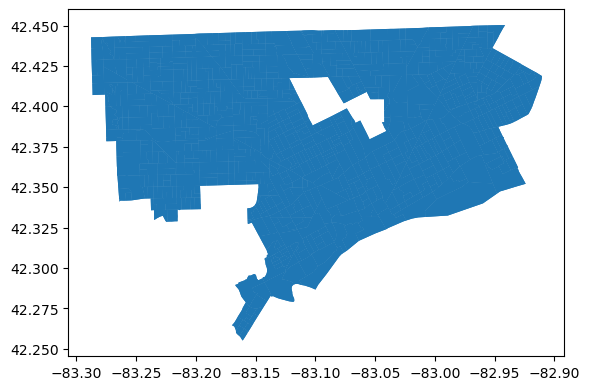

In [33]:
tract_fips_len = len(DF_DETROIT_TRACTS["geoid_10"].iloc[0])
tract_prefix = gdf_processed_table["geo_id"].str.slice(0, tract_fips_len)
gdf_processed_table["is_in_detroit"] = tract_prefix.isin(
    list(DF_DETROIT_TRACTS["geoid_10"])
)
gdf_processed_table[gdf_processed_table["is_in_detroit"]].plot()

# Population density

In [34]:
gdf_processed_table["density"] = (
    gdf_processed_table["tot_pop"] / gdf_processed_table.to_crs(PROJECTED_CRS).area
)

# Export

In [35]:
DF_RATE_TABLE.to_csv(UNPROCESSED_EXPORT_FP, index=False)

In [36]:
df_processed_table.to_csv(EXPORT_FP, index=False)

In [37]:
gdf_processed_table.to_file(MAP_EXPORT_FP, index=False)

## Clean export

- Filter for the minimum `generic_location_based_premium` in each geography
- Recalculate the location effect so that it only includes the min values

In [38]:
gdf_min_rate = gdf_processed_table.sort_values(
    by="generic_location_based_premium"
).drop_duplicates(subset=["geo_id"], keep="first")

median_loc_base_rate = gdf_min_rate["generic_location_based_premium"].median()
gdf_min_rate["location_effect"] = round(
    gdf_min_rate["generic_location_based_premium"] / median_loc_base_rate, 2
)

In [39]:
gdf_min_rate[CLEAN_EXPORT_COLS].to_csv(CLEAN_EXPORT_FP, index=False)
gdf_min_rate[CLEAN_EXPORT_COLS + ["geometry"]].to_file(
    CLEAN_MAP_EXPORT_FP, driver="GeoJSON"
)

# Appendix